In [2]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
# from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

In [3]:
EPOCHS = 15
BATCH_SIZE = 8
OUT = 3
INPUT_SHAPE = (35, 35, 3)
INPUT_SHAPE_FLATTENED = INPUT_SHAPE[0] * INPUT_SHAPE[1] * INPUT_SHAPE[2]

#### Models

In [4]:
def single_layer_softmax_model(learning_rate=0.001):
    model = tf.keras.models.Sequential([
#         out -> 10, init -> N(0, 1)
        tf.keras.layers.Input(shape = INPUT_SHAPE),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(OUT, 
                              kernel_initializer= tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), 
                              activation = 'softmax', 
                              input_shape = (INPUT_SHAPE_FLATTENED,))
    ])
    
    model.compile(
        # Adam, crossentropy
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC()],
    )
    
    return model

In [5]:
def multi_layer_model(learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = INPUT_SHAPE),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu", input_shape=(INPUT_SHAPE_FLATTENED,)),
        tf.keras.layers.Dense(256, activation="tanh"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", tf.keras.metrics.AUC()]
    )
    
    return model

In [6]:
def only_tanh_model(learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = INPUT_SHAPE),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="tanh", input_shape=(INPUT_SHAPE_FLATTENED,), kernel_initializer=tf.keras.initializers.GlorotNormal()),
        tf.keras.layers.Dense(256, activation="tanh"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

In [7]:
def only_relu_model(learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = INPUT_SHAPE),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu", input_shape=(INPUT_SHAPE_FLATTENED,), kernel_initializer=tf.keras.initializers.HeNormal()),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

#### Ploting

In [8]:
def plot_learning_metrics(result, title):
    accuracy_percentage = np.round(100 * result.history["accuracy"][-1], 3) 
    print(f"Accuracy: {accuracy_percentage}% \n")
    
    x_range = range(EPOCHS)
    
    fig, (loss_plt, accuracy_plt) = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
    
    loss_plt.plot(x_range, result.history["loss"], "r", label="TRAIN loss")
    loss_plt.plot(x_range, result.history["val_loss"], "g", label="TEST loss")
    loss_plt.legend()
    
    accuracy_plt.plot(x_range, result.history["accuracy"], "b", label="TRAIN accuracy")
    accuracy_plt.plot(x_range, result.history["val_accuracy"], "lightgreen", label="TEST accuracy")
    accuracy_plt.legend()
    
    plt.suptitle(f"TRAIN and TEST metrics -> {title}")
    
    fig.tight_layout()
    plt.show()

#### Fitting learning rate

No nessesity if using learning rate decay method, where the values of the $\alpha$ throught the epoch decreased by formula.

In [9]:
def fit_learning_rate(model_function, l, train_dataset, validation_dataset, model_name):
    learning_rates = [10 ** (-i) for i in range(1, l+1)]
    
    for current_rate in learning_rates:
        model = model_function(learning_rate=current_rate)
        
        result = model.fit(train_dataset, validation_data=validation_dataset, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=False)
        
        print(f"learning rate -> {current_rate}")
        plot_learning_metrics(result, model_name)

In [10]:
def model_with_checkpoints(learning_rate, training_set, validation_set):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = INPUT_SHAPE),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(OUT, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), activation="softmax", input_shape=(INPUT_SHAPE_FLATTENED,))
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    checkpoints = tf.keras.callbacks.ModelCheckpoint(
        "model.h5",
        monitor= "loss",
        verbose=True, 
        save_best_only=True
    )
    
    result = model.fit(
        training_set,
        validation_data=validation_set,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks = [checkpoints]
    )

#### Make generic activation method

In [11]:
def build_generic_activation(activation_method, learning_rate):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = INPUT_SHAPE),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=activation_method, input_shape=(INPUT_SHAPE_FLATTENED,)),
        tf.keras.layers.Dense(256, activation=activation_method),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics = ["accuracy", tf.keras.metrics.AUC()]
    )
    
    return model

In [12]:
def model_count_time(model, train_set, validation_set, test_set):
    prediciton_time = 0
    
    start = time.time()
    result = model.fit(
        train_set,
        validation_data=validation_set,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=False
    )
    end = time.time()
    
    learning_time = end - start
    train_accuracy = np.round(100 * result.history["accuracy"][-1], 3)
    
    start = time.time()
    _, accuracy, auc = model.evaluate(test_set, verbose=False)
    end = time.time()
    prediction_time = end - start
    test_accuracy = np.round(100 * accuracy, 3)
    
    print(f"Learning time: {learning_time}")
    print(f"Prediction time: {prediction_time}")
    print(f"Train accuracy: {train_accuracy}%, test accuracy {test_accuracy}%")

# Mask detection

In [13]:
input_data_path = "./mask_dataset/images"
annotations_path = "./mask_dataset/annotations"
images = [*os.listdir("./mask_dataset/images")]
output_data_path = "./mask_detection"

In [14]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result

In [15]:
def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
                    
    return params

In [16]:
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [17]:
import glob
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

full_dataset = sum(dataset, [])

df = pd.DataFrame(full_dataset)
df.shape

(4072, 9)

In [18]:
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss0,512,366,3,without_mask,79,105,109,142
1,maksssksksss0,512,366,3,with_mask,185,100,226,144
2,maksssksksss0,512,366,3,without_mask,325,90,360,141
3,maksssksksss1,400,156,3,with_mask,321,34,354,69
4,maksssksksss1,400,156,3,with_mask,224,38,261,73


In [19]:
final_test_image = 'maksssksksss3'
df_final_test = df.loc[df["file"] == final_test_image]
# images.remove(f'{final_test_image}.png') 
df = df.loc[df["file"] != final_test_image]

In [20]:
df_final_test.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
1106,maksssksksss3,400,271,3,with_mask,52,53,73,76
1107,maksssksksss3,400,271,3,with_mask,72,53,92,75
1108,maksssksksss3,400,271,3,with_mask,112,51,120,68
1109,maksssksksss3,400,271,3,with_mask,155,60,177,83
1110,maksssksksss3,400,271,3,with_mask,189,59,210,80


In [21]:
df.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)
df_final_test.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)

In [22]:
df["label"].value_counts()

with_mask                3223
without_mask              717
mask_weared_incorrect     123
Name: label, dtype: int64

Text(0, 0.5, 'Label')

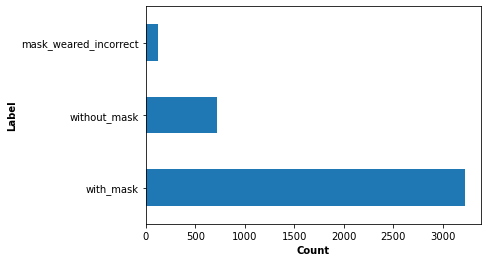

In [23]:
df["label"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Label', fontsize = 10, fontweight = 'bold')

#### Preparing the data 

In [24]:
labels = df["label"].unique()
directory = ["train", "test", "val"]
output_data_path = "./mask_dataset"

for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

Then extract faces from images 

In [25]:
def crop_image(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    image = Image.open(image_path)
    cropped = image.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [26]:
def extract_faces(image_name, image_info):
    
    '''
     This function takes an image name + dataframe with information about the image 
     and splits the image into all the different faces. image name contains the 
     upper-left coordinate of each face so we could distinguish it later
    '''
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'label']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_image(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [27]:
cropped_faces = [extract_faces(image, df) for image in images]

In [28]:
flat_cropped_faces = sum(cropped_faces, [])

In [29]:
with_mask = [(image, image_name) for image, label, image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(image, image_name) for image, label, image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(image, image_name) for image, label, image_name in flat_cropped_faces if label == "without_mask"]

Quntity of images with mask: 3223
Quntity of images with mask: 123
Quntity of images with mask: 717
Total quantity: 4063


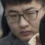

In [30]:
print(f"Quntity of images with mask: {len(with_mask)}")
print(f"Quntity of images with mask: {len(mask_weared_incorrect)}")
print(f"Quntity of images with mask: {len(without_mask)}")
print(f"Total quantity: {len(with_mask) + len(mask_weared_incorrect) + len(without_mask)}")
without_mask[10][0]

А хто тут у нас?
Чоловіче, одягніть маску!

In [31]:
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [32]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)

In [33]:
# Train set

for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
    
# Val set
    
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

In [34]:
datagen = ImageDataGenerator(
    rescale = 1.0 / 255, 
    horizontal_flip=True, 
    zoom_range=0.1, 
    shear_range=0.2, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    rotation_range=4, 
    vertical_flip=False
)

val_datagen = ImageDataGenerator(
    rescale = 1.0 / 255
)

In [35]:
train_dataset = datagen.flow_from_directory(
    directory="./mask_dataset/train",
    target_size=(35, 35),
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    shuffle = True
)

validation_dataset = val_datagen.flow_from_directory(
    directory = "./mask_dataset/val",
    target_size = (35, 35),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle=True
)

test_dataset = val_datagen.flow_from_directory(
    directory = "./mask_dataset/test",
    target_size = (35, 35),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 3876 images belonging to 3 classes.
Found 1036 images belonging to 3 classes.
Found 465 images belonging to 3 classes.


In [36]:
data_size = len(train_dataset)
steps_per_epoch = data_size // BATCH_SIZE
validation_steps = len(validation_dataset) // BATCH_SIZE

print(f" steps per epoch: {steps_per_epoch}, validation steps: {validation_steps}")

 steps per epoch: 60, validation steps: 16


Epoch 1/15
485/485 [==============================] - 4s 7ms/step - loss: 3.4644 - accuracy: 0.6932 - auc: 0.8127 - val_loss: 1.8411 - val_accuracy: 0.7683 - val_auc: 0.8740
Epoch 2/15
485/485 [==============================] - 3s 7ms/step - loss: 1.8589 - accuracy: 0.7730 - auc: 0.8854 - val_loss: 1.2604 - val_accuracy: 0.8427 - val_auc: 0.9213
Epoch 3/15
485/485 [==============================] - 3s 7ms/step - loss: 1.5111 - accuracy: 0.8008 - auc: 0.9031 - val_loss: 1.0114 - val_accuracy: 0.8687 - val_auc: 0.9375
Epoch 4/15
485/485 [==============================] - 3s 7ms/step - loss: 1.3100 - accuracy: 0.8269 - auc: 0.9194 - val_loss: 0.9385 - val_accuracy: 0.8649 - val_auc: 0.9467
Epoch 5/15
485/485 [==============================] - 4s 8ms/step - loss: 1.1593 - accuracy: 0.8442 - auc: 0.9292 - val_loss: 0.9668 - val_accuracy: 0.8678 - val_auc: 0.9438
Epoch 6/15
485/485 [==============================] - 4s 8ms/step - loss: 1.1045 - accuracy: 0.8421 - auc: 0.9332 - val_loss: 0.94

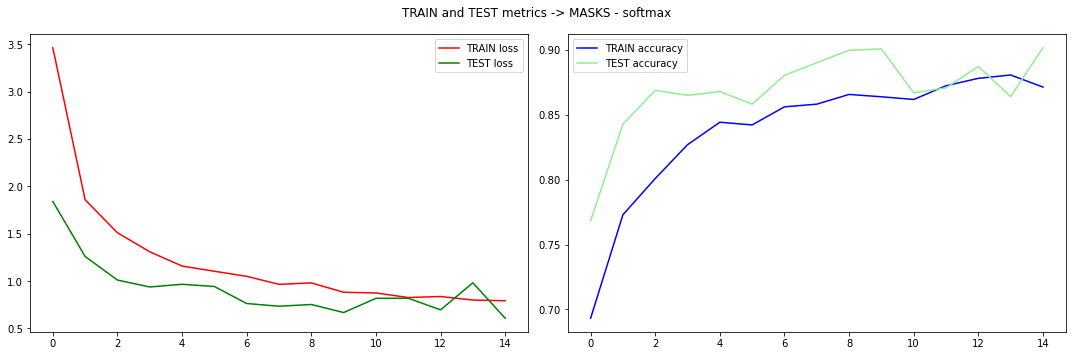

In [37]:
model = single_layer_softmax_model()
result = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)
plot_learning_metrics(result, "MASKS - softmax")

In [38]:
_, accuracy, auc = model.evaluate(test_dataset, verbose=False)
print("SOFTMAX")
print(f"On TEST accuracy: {accuracy}, auc: {auc}")

SOFTMAX
On TEST accuracy: 0.9096774458885193, auc: 0.9701191186904907


Epoch 1/15
485/485 [==============================] - 4s 8ms/step - loss: 0.5067 - accuracy: 0.7895 - auc_1: 0.9344 - val_loss: 0.3993 - val_accuracy: 0.8012 - val_auc_1: 0.9573
Epoch 2/15
485/485 [==============================] - 4s 8ms/step - loss: 0.4081 - accuracy: 0.8271 - auc_1: 0.9548 - val_loss: 0.3291 - val_accuracy: 0.8485 - val_auc_1: 0.9696
Epoch 3/15
485/485 [==============================] - 4s 8ms/step - loss: 0.3601 - accuracy: 0.8692 - auc_1: 0.9649 - val_loss: 0.2955 - val_accuracy: 0.9228 - val_auc_1: 0.9818
Epoch 4/15
485/485 [==============================] - 4s 8ms/step - loss: 0.3278 - accuracy: 0.8911 - auc_1: 0.9707 - val_loss: 0.2616 - val_accuracy: 0.9218 - val_auc_1: 0.9856
Epoch 5/15
485/485 [==============================] - 4s 9ms/step - loss: 0.3074 - accuracy: 0.9033 - auc_1: 0.9737 - val_loss: 0.2378 - val_accuracy: 0.9276 - val_auc_1: 0.9862
Epoch 6/15
485/485 [==============================] - 4s 9ms/step - loss: 0.2876 - accuracy: 0.9100 - auc_1: 0

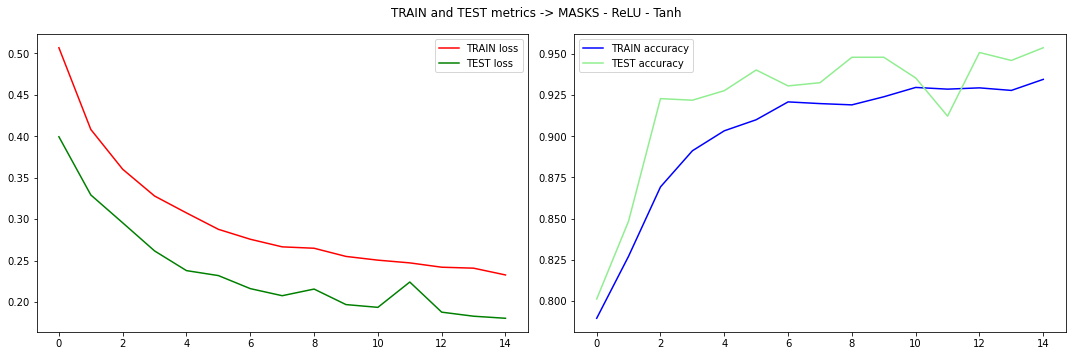

In [39]:
model = multi_layer_model()
result = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)
plot_learning_metrics(result, "MASKS - ReLU - Tanh")

In [40]:
_, accuracy, auc = model.evaluate(test_dataset, verbose=False)
print("MULTILAYER")
print(f"On TEST accuracy: {accuracy}, auc: {auc}")

MULTILAYER
On TEST accuracy: 0.9526881575584412, auc: 0.9893767833709717


learning rate -> 0.1
Accuracy: 92.595% 



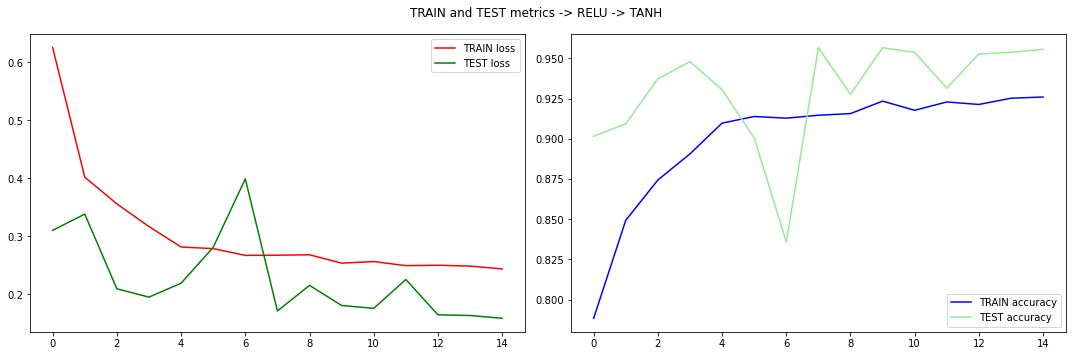

learning rate -> 0.01
Accuracy: 93.008% 



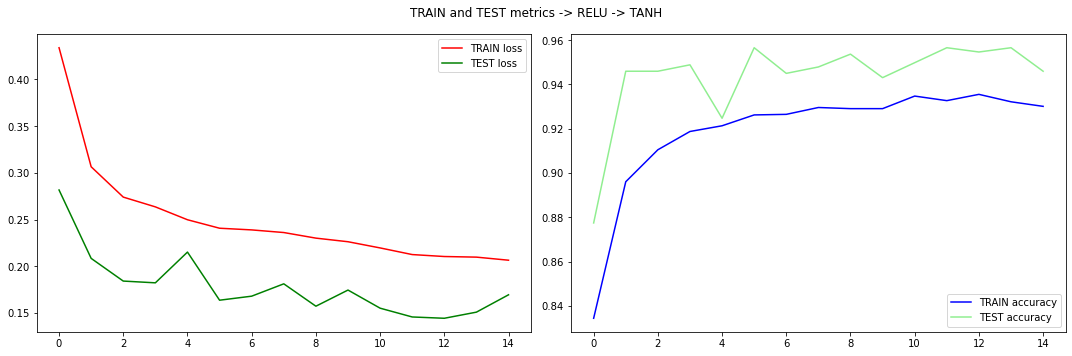

learning rate -> 0.001
Accuracy: 93.344% 



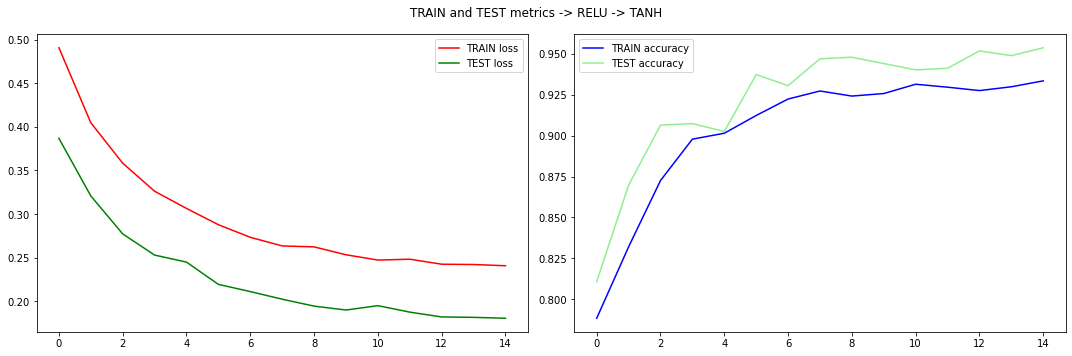

learning rate -> 0.0001
Accuracy: 83.256% 



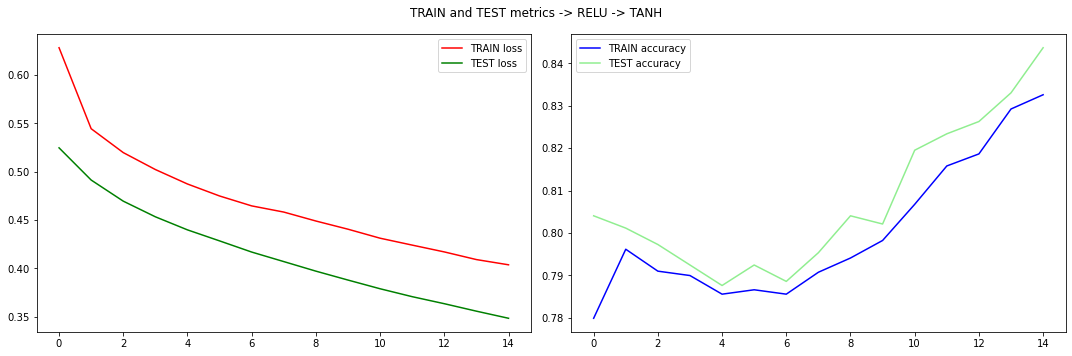

learning rate -> 1e-05
Accuracy: 79.67% 



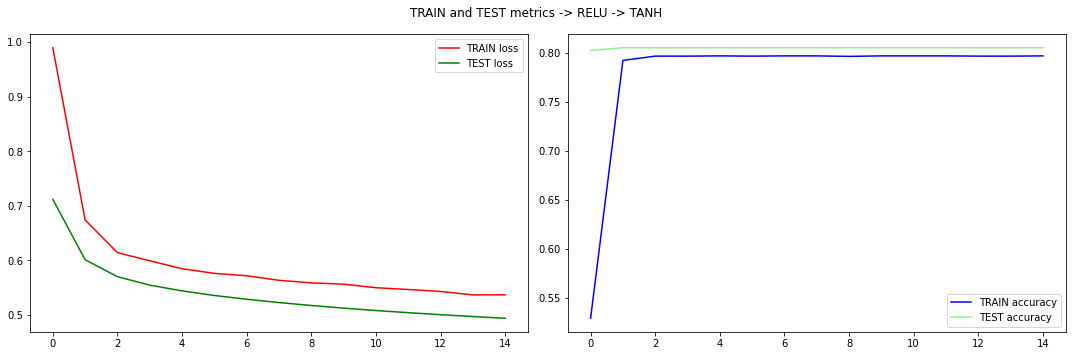

In [41]:
fit_learning_rate(multi_layer_model, 5, train_dataset, validation_dataset, "RELU -> TANH")

Epoch 1/15
485/485 [==============================] - 4s 8ms/step - loss: 0.4777 - accuracy: 0.7970 - auc_7: 0.9403 - val_loss: 0.3601 - val_accuracy: 0.8320 - val_auc_7: 0.9650
Epoch 2/15
485/485 [==============================] - 4s 8ms/step - loss: 0.3806 - accuracy: 0.8545 - auc_7: 0.9606 - val_loss: 0.2967 - val_accuracy: 0.8851 - val_auc_7: 0.9788
Epoch 3/15
485/485 [==============================] - 4s 8ms/step - loss: 0.3355 - accuracy: 0.8870 - auc_7: 0.9692 - val_loss: 0.2616 - val_accuracy: 0.9170 - val_auc_7: 0.9836
Epoch 4/15
485/485 [==============================] - 4s 8ms/step - loss: 0.3160 - accuracy: 0.8909 - auc_7: 0.9724 - val_loss: 0.2460 - val_accuracy: 0.9257 - val_auc_7: 0.9861
Epoch 5/15
485/485 [==============================] - 4s 8ms/step - loss: 0.2971 - accuracy: 0.9048 - auc_7: 0.9750 - val_loss: 0.2349 - val_accuracy: 0.9286 - val_auc_7: 0.9865
Epoch 6/15
485/485 [==============================] - 4s 8ms/step - loss: 0.2800 - accuracy: 0.9131 - auc_7: 0

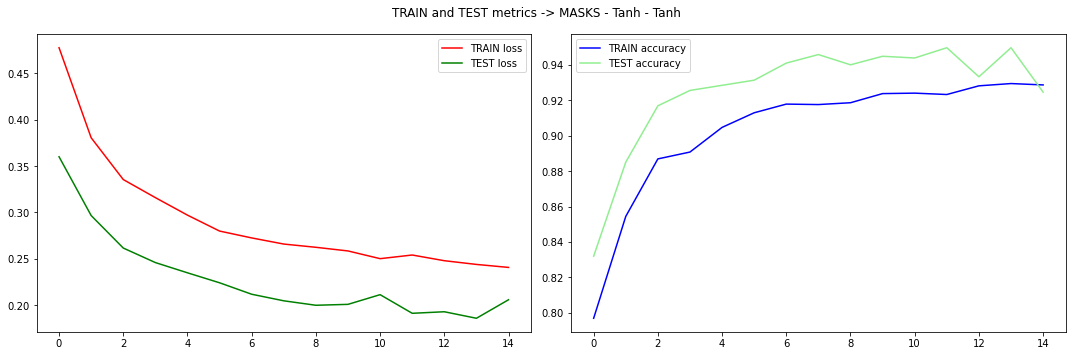

TANH
On TEST accuracy: 0.9354838728904724, auc: 0.9868447184562683


In [42]:
model = only_tanh_model()
result = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)
plot_learning_metrics(result, "MASKS - Tanh - Tanh")

_, accuracy, auc = model.evaluate(test_dataset, verbose=False)
print("TANH")
print(f"On TEST accuracy: {accuracy}, auc: {auc}")

learning rate -> 0.1
Accuracy: 92.028% 



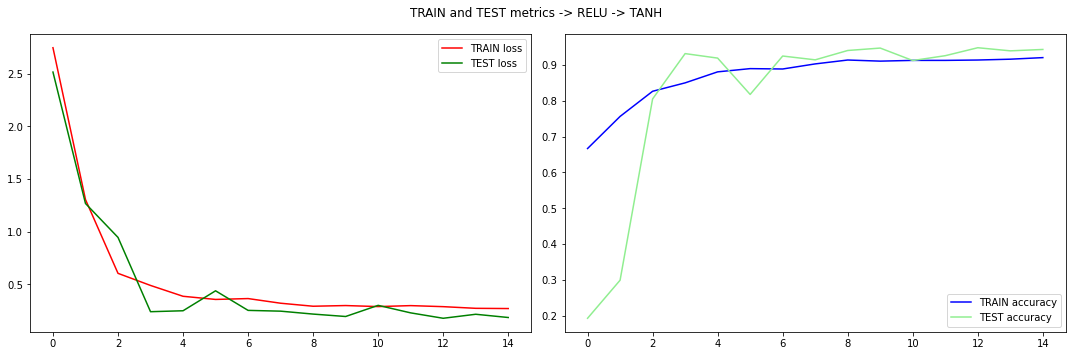

learning rate -> 0.01
Accuracy: 93.369% 



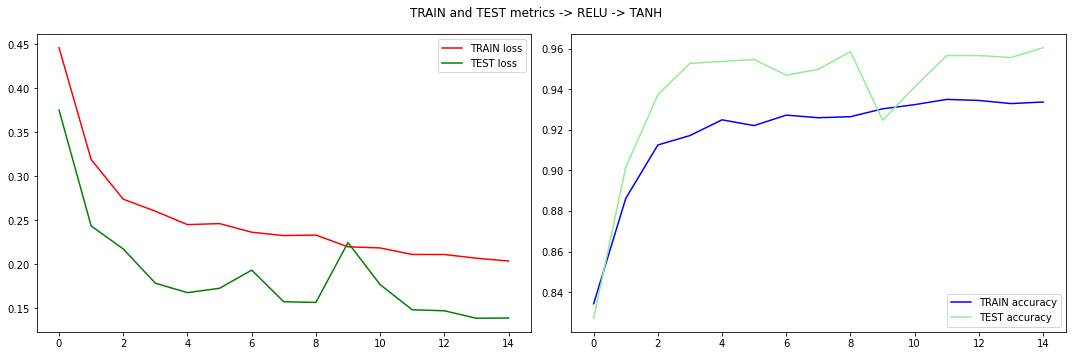

learning rate -> 0.001
Accuracy: 92.853% 



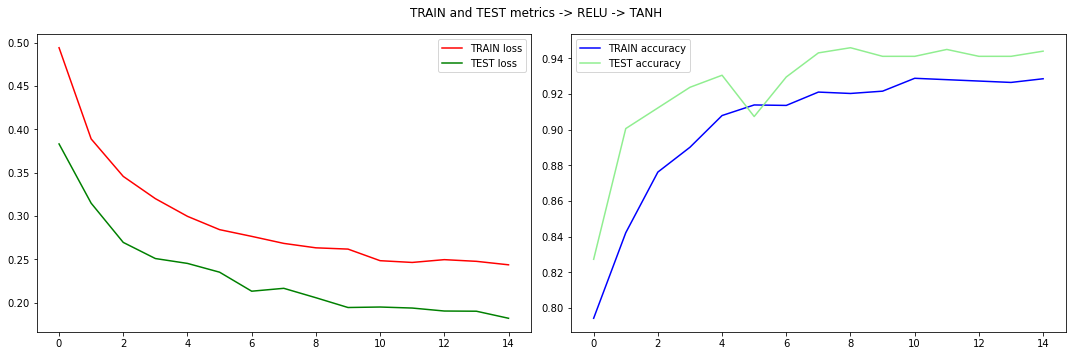

learning rate -> 0.0001
Accuracy: 84.262% 



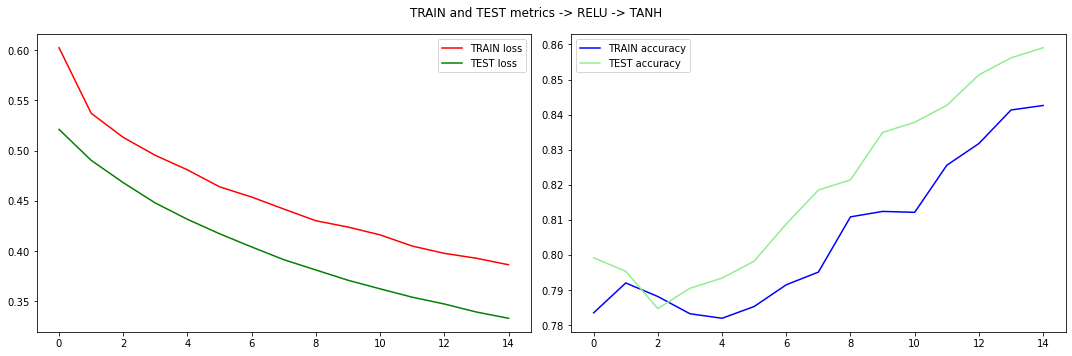

learning rate -> 1e-05
Accuracy: 79.205% 



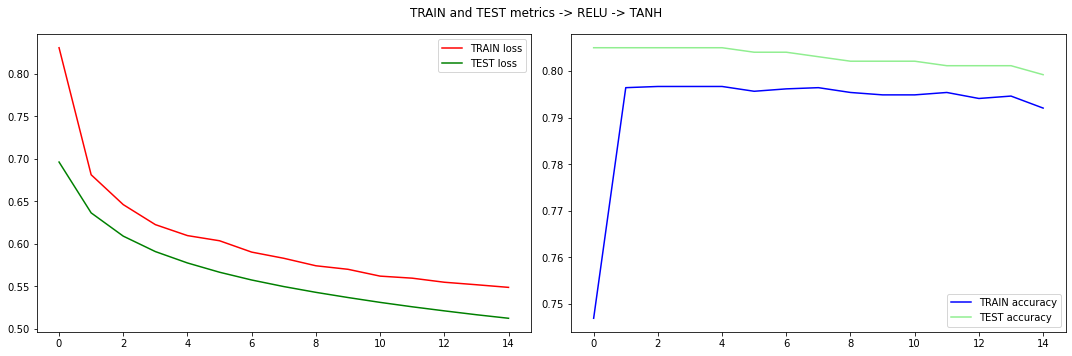

In [43]:
fit_learning_rate(only_tanh_model, 5, train_dataset, validation_dataset, "RELU -> TANH")

Epoch 1/15
485/485 [==============================] - 4s 8ms/step - loss: 0.4914 - accuracy: 0.8011 - auc_13: 0.9373 - val_loss: 0.3898 - val_accuracy: 0.8475 - val_auc_13: 0.9642
Epoch 2/15
485/485 [==============================] - 4s 8ms/step - loss: 0.3994 - accuracy: 0.8449 - auc_13: 0.9572 - val_loss: 0.3208 - val_accuracy: 0.8620 - val_auc_13: 0.9724
Epoch 3/15
485/485 [==============================] - 4s 8ms/step - loss: 0.3501 - accuracy: 0.8878 - auc_13: 0.9674 - val_loss: 0.2784 - val_accuracy: 0.8996 - val_auc_13: 0.9799
Epoch 4/15
485/485 [==============================] - 4s 8ms/step - loss: 0.3221 - accuracy: 0.8950 - auc_13: 0.9721 - val_loss: 0.2513 - val_accuracy: 0.9353 - val_auc_13: 0.9841
Epoch 5/15
485/485 [==============================] - 4s 9ms/step - loss: 0.2993 - accuracy: 0.9092 - auc_13: 0.9749 - val_loss: 0.2398 - val_accuracy: 0.9218 - val_auc_13: 0.9862
Epoch 6/15
485/485 [==============================] - 4s 9ms/step - loss: 0.2870 - accuracy: 0.9164 

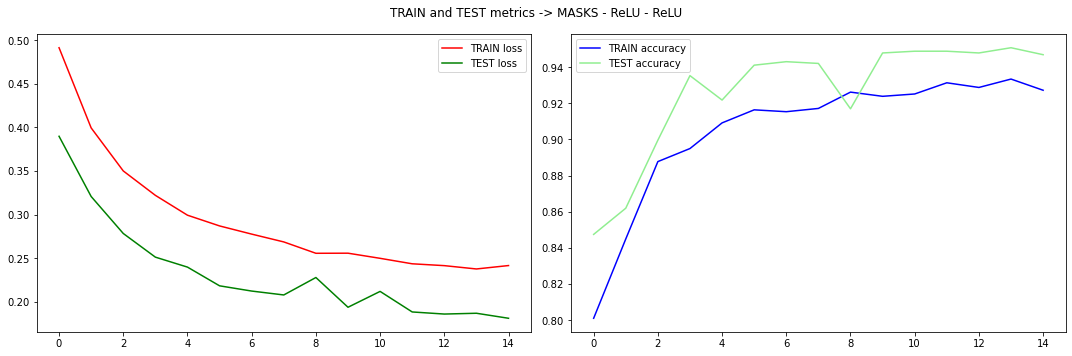

RELU
On TEST accuracy: 0.9505376219749451, auc: 0.9894335269927979


In [44]:
model = only_relu_model()
result = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)
plot_learning_metrics(result, "MASKS - ReLU - ReLU")

_, accuracy, auc = model.evaluate(test_dataset, verbose=False)
print("RELU")
print(f"On TEST accuracy: {accuracy}, auc: {auc}")

learning rate -> 0.1
Accuracy: 92.157% 



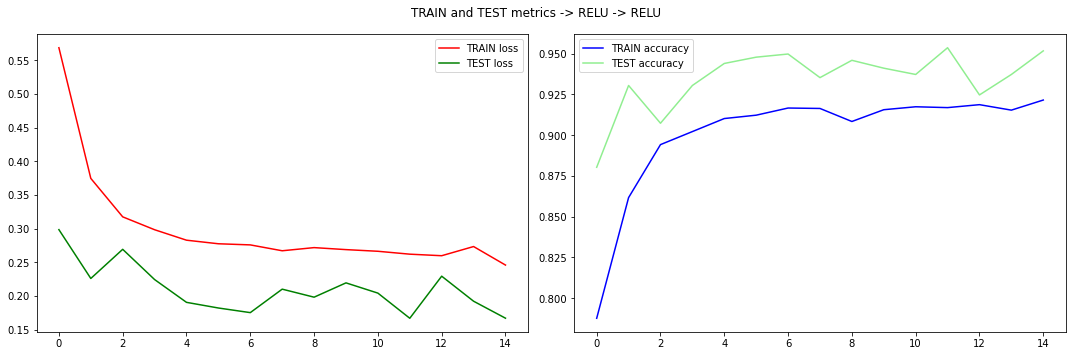

learning rate -> 0.01
Accuracy: 93.111% 



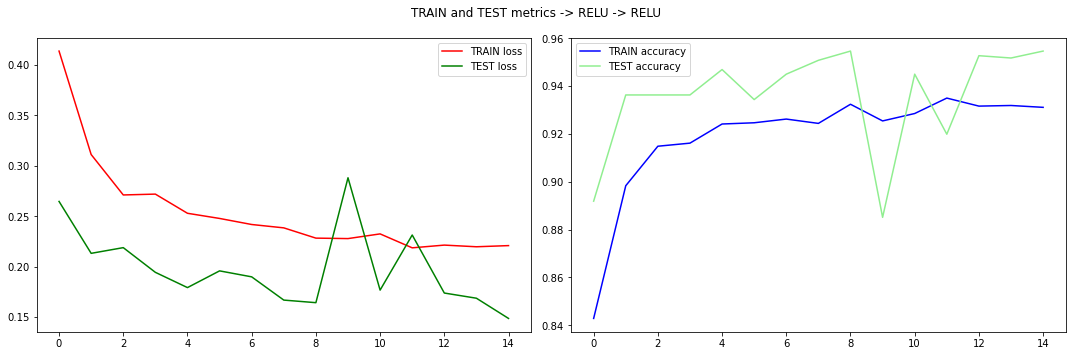

learning rate -> 0.001
Accuracy: 92.802% 



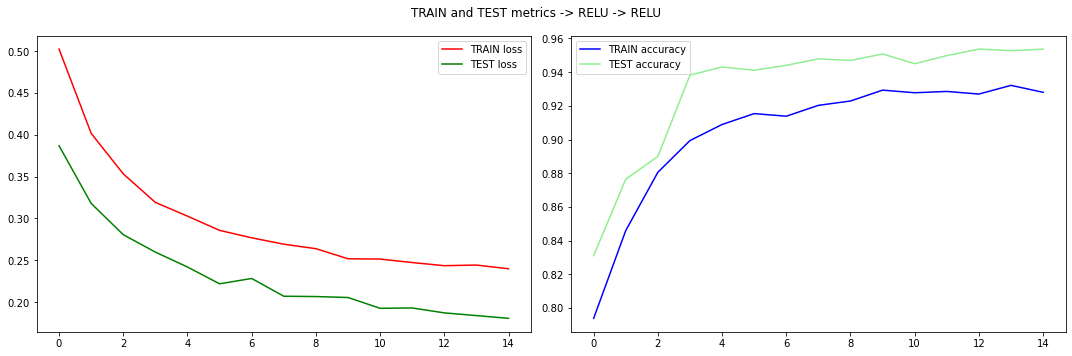

In [45]:
fit_learning_rate(only_relu_model, 3, train_dataset, validation_dataset, "RELU -> RELU")

#### Conclusion about Masks:
- The worst accuracy metrics value when using traditional method
- Retraining the model is absent because of approximate match of two sets: TRAIN and TEST

#### Saving controll points

In [46]:
model_with_checkpoints(0.001, train_dataset, validation_dataset)

Epoch 1/15
480/485 [============================>.] - ETA: 0s - loss: 3.4572 - accuracy: 0.7198 - auc_17: 0.8353
Epoch 00001: loss improved from inf to 3.44186, saving model to model.h5
485/485 [==============================] - 3s 6ms/step - loss: 3.4419 - accuracy: 0.7206 - auc_17: 0.8359 - val_loss: 2.7097 - val_accuracy: 0.6921 - val_auc_17: 0.8214
Epoch 2/15
485/485 [==============================] - ETA: 0s - loss: 2.0725 - accuracy: 0.7799 - auc_17: 0.8813
Epoch 00002: loss improved from 3.44186 to 2.07252, saving model to model.h5
485/485 [==============================] - 3s 6ms/step - loss: 2.0725 - accuracy: 0.7799 - auc_17: 0.8813 - val_loss: 1.7102 - val_accuracy: 0.7770 - val_auc_17: 0.8893
Epoch 3/15
481/485 [============================>.] - ETA: 0s - loss: 1.6321 - accuracy: 0.8018 - auc_17: 0.9022
Epoch 00003: loss improved from 2.07252 to 1.63200, saving model to model.h5
485/485 [==============================] - 3s 6ms/step - loss: 1.6320 - accuracy: 0.8021 - auc_1

In [47]:
x, y = test_dataset.next()
print(f"Shapes are: X={x[0].shape}, y={y[0].shape}")

Shapes are: X=(35, 35, 3), y=(3,)


(35, 35, 3)
[0. 0. 1.]


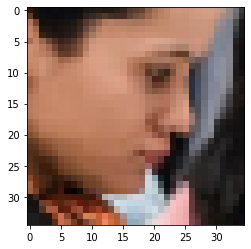

In [97]:
sample_num = 2 # what we are predicting

# print('label: ', np.where(test_dataset[sample_num] == 1)[0][0])
# image = X_test[sample_num].reshape(28, 28)
print(x[sample_num].shape)
print(y[sample_num])
plt.imshow(x[sample_num])
plt.show()

(35, 35, 3)
[0. 1. 0.]


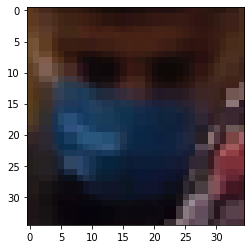

In [115]:
x, y = test_dataset.next()
sample_num = 0 # what we are predicting

# print('label: ', np.where(test_dataset[sample_num] == 1)[0][0])
# image = X_test[sample_num].reshape(28, 28)
print(x[sample_num].shape)
print(y[sample_num])
plt.imshow(x[sample_num])
plt.show()

#### Activation method functions: LeakyReLU, Parametrics LeakyReLU, ELU
Description of: 
- train time
- network quality on test
- prediction time

- LeakyReLU 
- Parametric LeakyReLU 
- ELU
Learning time: 64.99218487739563
Prediction time: 0.23713445663452148
Train accuracy: 92.75%, test accuracy 95.269%
On TEST accuracy: 0.9569892287254333, auc: 0.9915065765380859
AUC on TEST: 0.9915065765380859
Accuracy: 93.602% 



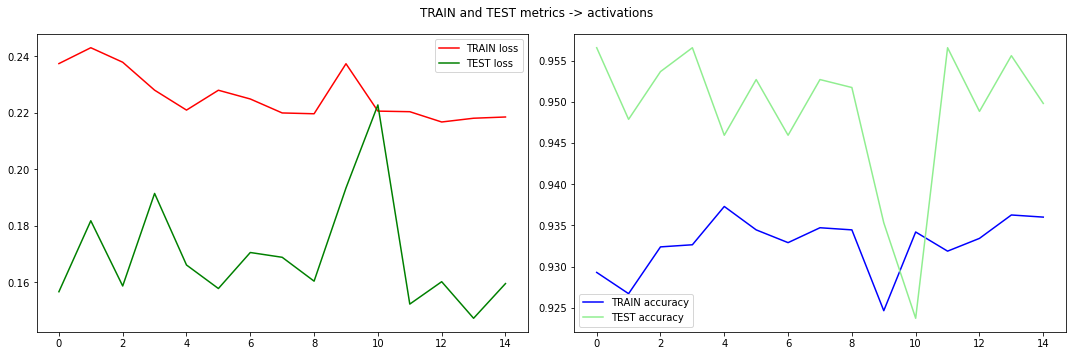

Learning time: 65.96750950813293
Prediction time: 0.21068382263183594
Train accuracy: 92.853%, test accuracy 95.484%
On TEST accuracy: 0.948387086391449, auc: 0.9932432174682617
AUC on TEST: 0.9932432174682617
Accuracy: 93.06% 



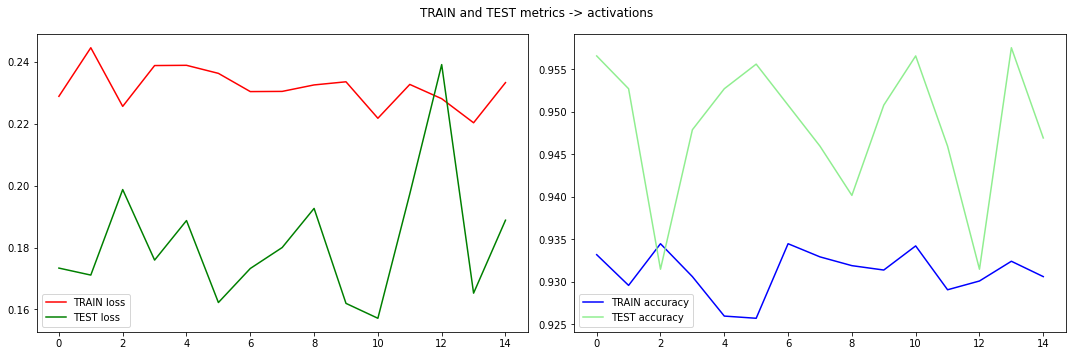

Learning time: 67.52645206451416
Prediction time: 0.2586669921875
Train accuracy: 92.905%, test accuracy 95.914%
On TEST accuracy: 0.9569892287254333, auc: 0.993504524230957
AUC on TEST: 0.993504524230957
Accuracy: 93.705% 



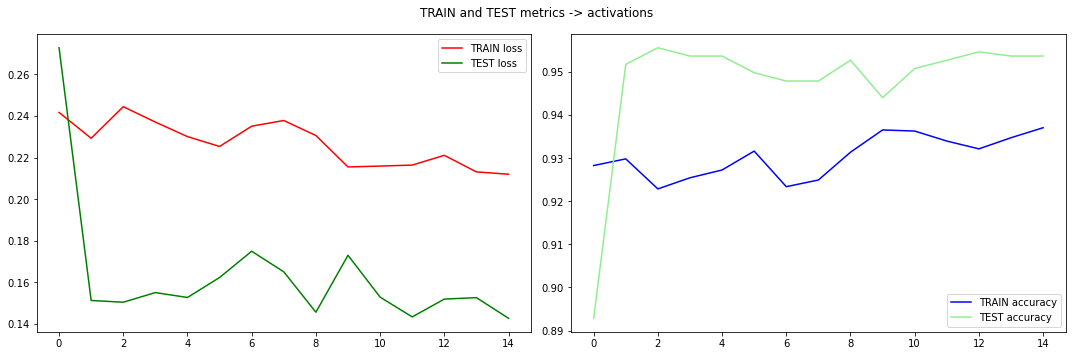

In [77]:
learning_rate = 0.001
param = 0.01

activations = [
    tf.keras.layers.LeakyReLU(alpha=learning_rate),
    tf.keras.layers.LeakyReLU(alpha=param),
    tf.keras.activations.elu,
]
print("- LeakyReLU \n- Parametric LeakyReLU \n- ELU")
for activation in activations:
    model = build_generic_activation(activation, learning_rate)
    model_count_time(model, train_dataset, validation_dataset, test_dataset)
    
    result = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=False
    )
    
    _, accuracy, auc = model.evaluate(test_dataset, verbose=False)
    print(f"On TEST accuracy: {accuracy}, auc: {auc}")
    print(f"AUC on TEST: {auc}")

    plot_learning_metrics(result, "activations")

In [51]:
learning_rate= 0.01

In [52]:
def build_model(activations, optimizer):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Input(shape = INPUT_SHAPE))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation=activations[0], input_shape=(INPUT_SHAPE_FLATTENED,)))
    model.add(tf.keras.layers.Dense(256, activation=activations[1]))
    model.add(tf.keras.layers.Dense(OUT, activation="softmax"))
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=optimizer,
                  metrics=["accuracy", tf.keras.metrics.AUC()])
    
    return model

On TEST accuracy: 0.9462365508079529, auc: 0.9858793616294861
Accuracy: 75.181% 



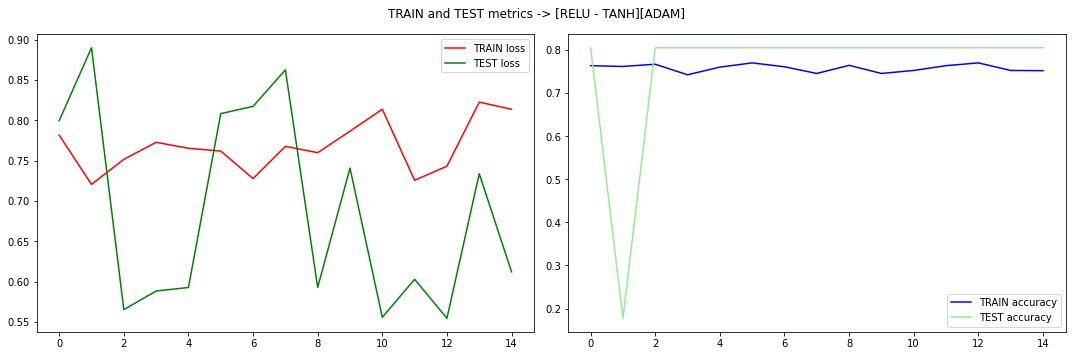

In [53]:
model_adam = build_model(["relu", "tanh"], tf.keras.optimizers.Adam(learning_rate=learning_rate))
result = model_adam.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose=False)
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
plot_learning_metrics(result, "[RELU - TANH][ADAM]")

On TEST accuracy: 0.8086021542549133, auc: 0.896774172782898
Accuracy: 76.006% 



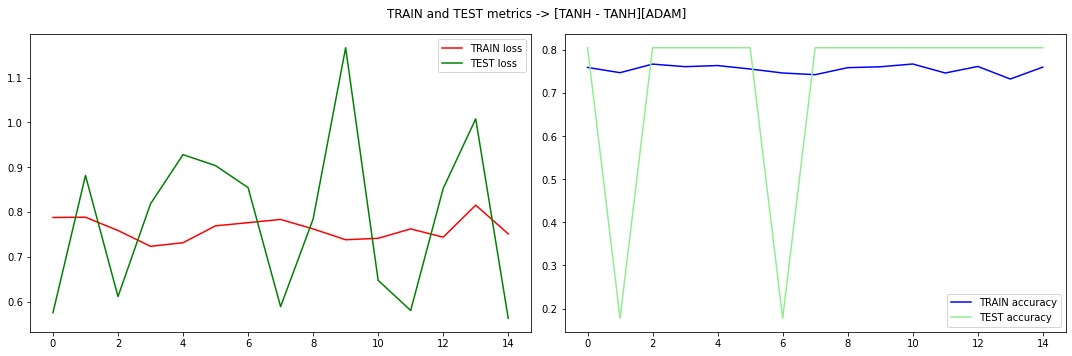

In [54]:
model_adam = build_model(["tanh", "tanh"], tf.keras.optimizers.Adam(learning_rate=learning_rate))
result = model_adam.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose=False)
_, accuracy, auc = model_adam.evaluate(test_dataset, verbose=False)
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
plot_learning_metrics(result, "[TANH - TANH][ADAM]")

On TEST accuracy: 0.8086021542549133, auc: 0.896774172782898
Accuracy: 79.67% 



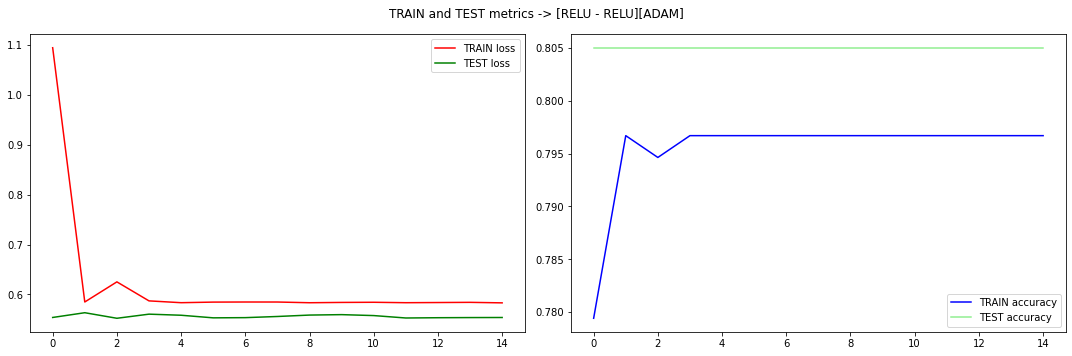

In [55]:
model_adam = build_model(["relu", "relu"], tf.keras.optimizers.Adam(learning_rate=learning_rate))
result = model_adam.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose=False)
_, accuracy, auc = model_adam.evaluate(test_dataset, verbose=False)
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
plot_learning_metrics(result, "[RELU - RELU][ADAM]")

<table>
    <tr>
        <td>layers activation</td>
        <td>Accuracy w/o Adam</td>
        <td>Accuracy with Adam</td>
    </tr>
    <tr>
        <td>ReLU - TANH</td>
        <td>95%</td>
        <td>80%</td>
    </tr>
    <tr>
        <td>TANH - TANH</td>
        <td>94%</td>
        <td>80%</td>
    </tr>
    <tr>
        <td>ReLU - ReLU</td>
        <td>95%</td>
        <td>93%</td>
    </tr>
</table>

#### Minibatch normalization

In [56]:
def build_model_with_batch_normalization1(learning_rate=0.0001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = INPUT_SHAPE),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", input_shape=(INPUT_SHAPE_FLATTENED,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="tanh"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=["accuracy", tf.keras.metrics.AUC()])
    
    return model

In [57]:
model = build_model_with_batch_normalization1()
result = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=False)

On TEST accuracy: 0.9548386931419373, auc: 0.9913989901542664
AUC on TEST: 0.9913989901542664
Accuracy: 89.164% 



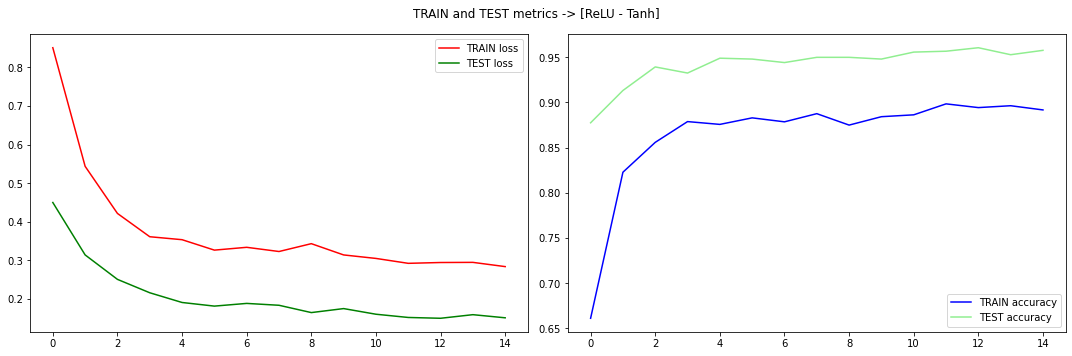

In [58]:
_, accuracy, auc = model.evaluate(test_dataset, verbose=False)
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
print(f"AUC on TEST: {auc}")

plot_learning_metrics(result, "[ReLU - Tanh]")

In [59]:
def build_model_with_batch_normalization2(learning_rate=0.0001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = INPUT_SHAPE),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), input_shape=(INPUT_SHAPE_FLATTENED,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="tanh"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=["accuracy", tf.keras.metrics.AUC()])
    
    return model

On TEST accuracy: 0.9419354796409607, auc: 0.9914417862892151
Accuracy: 88.364% 



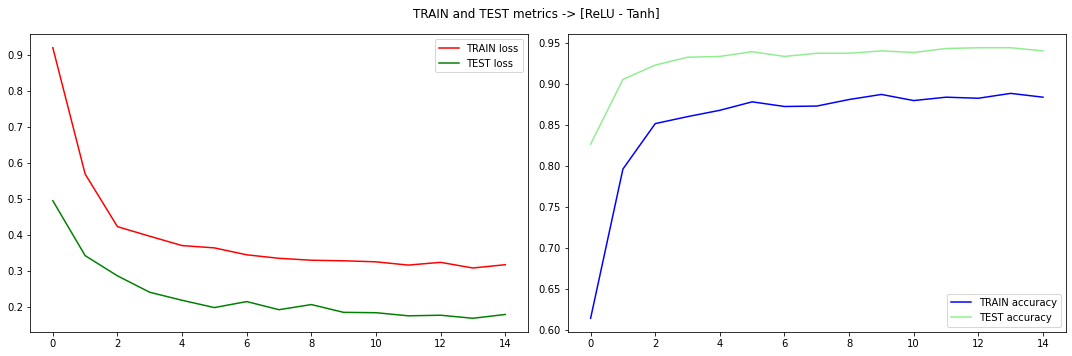

In [60]:
model = build_model_with_batch_normalization2()
result = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=False)

_, accuracy, auc = model.evaluate(test_dataset, verbose=False)
print(f"On TEST accuracy: {accuracy}, auc: {auc}")

plot_learning_metrics(result, "[ReLU - Tanh]")

In [61]:
model_count_time(build_model_with_batch_normalization1(), train_dataset, validation_dataset, test_dataset)
model_count_time(build_model_with_batch_normalization2(), train_dataset, validation_dataset, test_dataset)

Learning time: 83.56095337867737
Prediction time: 0.31886959075927734
Train accuracy: 88.958%, test accuracy 95.484%
Learning time: 80.92732524871826
Prediction time: 0.2736687660217285
Train accuracy: 89.654%, test accuracy 93.333%


#### Dropout usage

In [62]:
def model_with_dropout(learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = INPUT_SHAPE),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), input_shape=(INPUT_SHAPE_FLATTENED,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation="tanh"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=["accuracy", tf.keras.metrics.AUC()])
    
    return model

In [63]:
model_with_dropout = model_with_dropout()
result = model_with_dropout.fit(train_dataset,
                                validation_data=validation_dataset,
                                epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                verbose=False)

In [64]:
_, accuracy, auc = model_with_dropout.evaluate(test_dataset, verbose=False)

print(f'Test accuracy: {np.round(100 * accuracy, 3)}%')
print(f'Test AUC: {np.round(100 * auc, 3)}%')

Test accuracy: 90.108%
Test AUC: 98.07%


Accuracy: 83.669% 



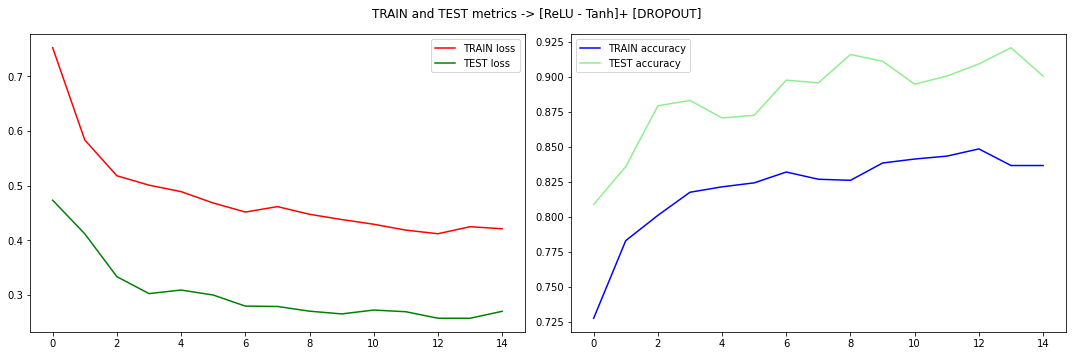

In [65]:
plot_learning_metrics(result, "[ReLU - Tanh]+ [DROPOUT]")

#### Early stopping implementation

In [66]:
def model_with_early_stopping(learning_rate=0.001):
    model = multi_layer_model()
    callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=1)
    
    return model, callback

In [67]:
model, callback = model_with_early_stopping()
result = model.fit(train_dataset,
                   validation_data=validation_dataset,
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE, 
                   verbose=2, 
                   callbacks=[callback])

Epoch 1/15
485/485 - 4s - loss: 0.5045 - accuracy: 0.7843 - auc_29: 0.9326 - val_loss: 0.3942 - val_accuracy: 0.8041 - val_auc_29: 0.9563 - 4s/epoch - 8ms/step
Epoch 2/15
485/485 - 3s - loss: 0.4026 - accuracy: 0.8315 - auc_29: 0.9554 - val_loss: 0.3213 - val_accuracy: 0.8629 - val_auc_29: 0.9714 - 3s/epoch - 7ms/step
Epoch 3/15
485/485 - 3s - loss: 0.3550 - accuracy: 0.8718 - auc_29: 0.9660 - val_loss: 0.2840 - val_accuracy: 0.8793 - val_auc_29: 0.9791 - 3s/epoch - 7ms/step
Epoch 4/15
485/485 - 3s - loss: 0.3195 - accuracy: 0.8950 - auc_29: 0.9726 - val_loss: 0.2617 - val_accuracy: 0.8909 - val_auc_29: 0.9809 - 3s/epoch - 7ms/step
Epoch 5/15
485/485 - 3s - loss: 0.2977 - accuracy: 0.9048 - auc_29: 0.9757 - val_loss: 0.2361 - val_accuracy: 0.9353 - val_auc_29: 0.9863 - 3s/epoch - 7ms/step
Epoch 6/15
485/485 - 3s - loss: 0.2840 - accuracy: 0.9141 - auc_29: 0.9772 - val_loss: 0.2214 - val_accuracy: 0.9431 - val_auc_29: 0.9861 - 3s/epoch - 7ms/step
Epoch 7/15
485/485 - 3s - loss: 0.2721 -

In [68]:
_, accuracy, auc = model.evaluate(test_dataset, verbose = False)

print(f'Test accuracy: {np.round(100 * accuracy, 3)}%')
print(f'Test AUC: {np.round(100 * auc, 3)}%')

Test accuracy: 95.054%
Test AUC: 98.881%


#### L-1 L-2 regularization

In [70]:
def model_regularization(learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = INPUT_SHAPE),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l1", input_shape=(INPUT_SHAPE_FLATTENED,)),
        tf.keras.layers.Dense(256, activation="tanh", kernel_regularizer="l2"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), 
                metrics=["accuracy", tf.keras.metrics.AUC()])
    
    return model

In [71]:
model = model_regularization()
result = model.fit(train_dataset,
                   validation_data = validation_dataset,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=False)

In [72]:
_, accuracy, auc = model.evaluate(test_dataset, verbose=False)

print(f'Test accuracy: {np.round(100 * accuracy, 3)}%')
print(f'Test AUC: {np.round(100 * auc, 3)}%')

Test accuracy: 88.602%
Test AUC: 96.339%


Accuracy: 86.584% 



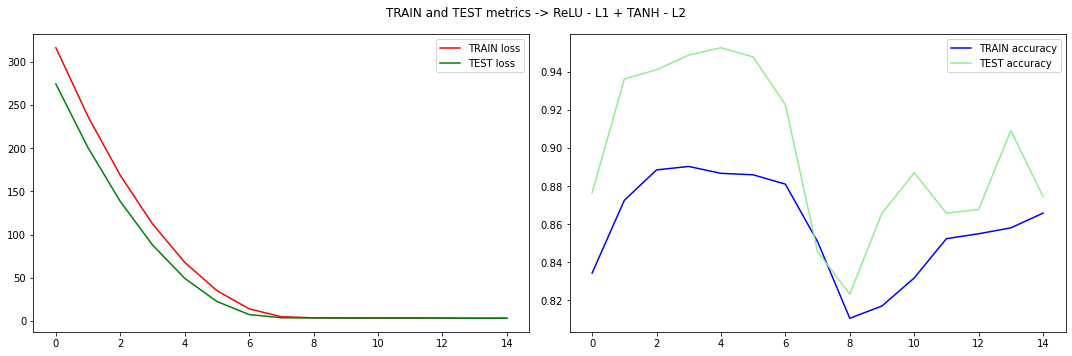

In [73]:
plot_learning_metrics(result, "ReLU - L1 + TANH - L2")

The best is model ReLU -> Tanh -> softmax that uses activation pf leaky RElu with $\alpha = 0.001$.
Accuracy is 98.3%

### Usage of the best model: LeakyReLU

In [80]:
# Adam + LeakyReLU - 0.001
best_model = build_generic_activation(tf.keras.layers.LeakyReLU(alpha=learning_rate), learning_rate=0.001)
    
result = best_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False
)
    
_, accuracy, auc = best_model.evaluate(test_dataset, verbose=False)
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
print(f"AUC on TEST: {auc}")

On TEST accuracy: 0.9591397643089294, auc: 0.9874402284622192
AUC on TEST: 0.9874402284622192


In [133]:
def check_mask(category_array):
    if category_array[0] == 1:
        print("Weared incorrect")
    elif category_array[1] == 1:
        print("Mask is present")
    elif category_array[2] == 1:
        print("Mask is absent")

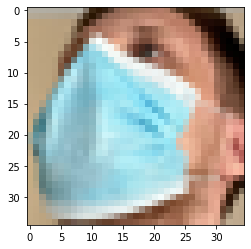

Mask is present


In [134]:
mask_test2_img = Image.open("./mask_dataset/custom_check/mask_test1.jpg").resize((35, 35))
mask_test2_img = np.array(mask_test2_img)

plt.imshow(mask_test2_img)
plt.show()

prediction1 = best_model.predict(mask_test2_img[None,:,:])[0]
check_mask(prediction1)

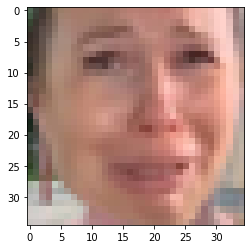

Mask is absent


In [135]:
mask_test1_img = Image.open("./mask_dataset/custom_check/mask_test5.jpg").resize((35, 35))
mask_test1_img = np.array(mask_test1_img)

plt.imshow(mask_test1_img)
plt.show()

# best_model.predict(mask_test1_img[None,:,:])
# mask_test1_img.shape

prediction2 = best_model.predict(mask_test1_img[None,:,:])[0]
check_mask(prediction2)

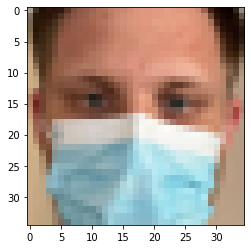

Mask is present


In [136]:
mask_test3_img = Image.open("./mask_dataset/custom_check/mask_test2.jpg").resize((35, 35))
mask_test3_img = np.array(mask_test3_img)

plt.imshow(mask_test3_img)
plt.show()

# best_model.predict(mask_test1_img[None,:,:])
# mask_test1_img.shape

prediciton3 = best_model.predict(mask_test3_img[None,:,:])[0]
check_mask(prediciton3)

Wear mask - save you life - live longer 🫁